In [42]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
#Set your project path 

import os
project_path =  '/content/drive/My Drive/Colab Notebooks/caps/'

In [0]:
os.chdir(project_path)

In [45]:
pwd


'/content/drive/My Drive/Colab Notebooks/caps'

In [46]:
ls


input_data.xlsx


In [47]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from pandas import read_excel

df =  read_excel('./input_data.xlsx', 'Sheet1')
df.head(10)

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0
5,unable to log in to engineering tool and skype,unable to log in to engineering tool and skype,eflahbxn ltdgrvkz,GRP_0
6,event: critical:HostName_221.company.com the v...,event: critical:HostName_221.company.com the v...,jyoqwxhz clhxsoqy,GRP_1
7,ticket_no1550391- employment status - new non-...,ticket_no1550391- employment status - new non-...,eqzibjhw ymebpoih,GRP_0
8,unable to disable add ins on outlook,unable to disable add ins on outlook,mdbegvct dbvichlg,GRP_0
9,ticket update on inplant_874773,ticket update on inplant_874773,fumkcsji sarmtlhy,GRP_0


In [48]:
len(df)

8500

In [49]:
df.describe().transpose()

,count,unique,top,freq
Short description,8492,7481,password reset,38
Description,8499,7817,the,56
Caller,8500,2950,bpctwhsn kzqsbmtp,810
Assignment group,8500,74,GRP_0,3976


In [50]:
df.dtypes

Short description    object
Description          object
Caller               object
Assignment group     object
dtype: object

In [51]:
df.describe()

,Short description,Description,Caller,Assignment group
count,8492,8499,8500,8500
unique,7481,7817,2950,74
top,password reset,the,bpctwhsn kzqsbmtp,GRP_0
freq,38,56,810,3976


In [52]:
## let us count the tickets by group

df['Assignment group'].value_counts()

GRP_0     3976
GRP_8      661
GRP_24     289
GRP_12     257
GRP_9      252
          ... 
GRP_64       1
GRP_73       1
GRP_70       1
GRP_67       1
GRP_61       1
Name: Assignment group, Length: 74, dtype: int64

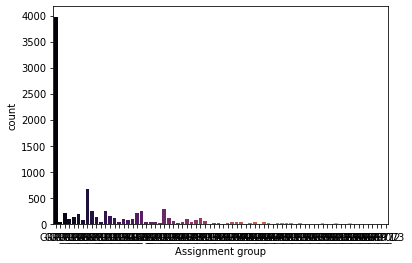

In [53]:
# Number of groups for overall ticker assignment using count plot
sns.countplot('Assignment group',data = df,palette='inferno')

Grp_0 has highest number of tickets assigned... 

In [0]:
### Description is missing for few of the tickets.. lets remove

In [55]:
df.isnull().values.any() ## Check for missing values

True

In [56]:
df.isnull().sum()

Short description    8
Description          1
Caller               0
Assignment group     0
dtype: int64

In [0]:
# drop rows with missing values
df.dropna(inplace=True)

In [58]:
df.isnull().sum()

Short description    0
Description          0
Caller               0
Assignment group     0
dtype: int64

In [59]:
df.shape

(8491, 4)

In [0]:
# dropping duplicate rows
df.drop_duplicates(keep=False,inplace=True)

In [61]:
df.shape

(8351, 4)

In [0]:
## Lets convert the description, short description, caller and group to lower case

df['Short description'] = df['Short description'].apply(lambda x: x.lower())
df['Description'] = df['Description'].apply(lambda x: x.lower())
df['Caller'] = df['Caller'].apply(lambda x: x.lower())
df['Assignment group'] = df['Assignment group'].apply(lambda x: x.lower())


In [63]:
df.head()

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,grp_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,grp_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,grp_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,grp_0
4,skype error,skype error,owlgqjme qhcozdfx,grp_0


In [64]:
df.shape

(8351, 4)

In [0]:
# dropping duplicate rows.... in case case sensitive duplicates were present earlier
df.drop_duplicates(keep=False,inplace=True)

In [66]:
df.shape

(8351, 4)

In [0]:
df_copy = df.copy()

In [0]:
## Remove mail Ids from the fields
mailId = r'\S*@\S*\s?'
df = df.replace(to_replace=mailId, value='', regex=True)

In [0]:
## Combine short description and description
df['TicketDescription'] = df['Short description'].str.cat(df['Description'],sep=" ")

In [0]:
df = df.drop(['Short description', 'Description'], axis=1)

In [0]:
df = df.drop(['Caller'], axis=1) ## Delete the caller as well

In [72]:
df.head()

,Assignment group,TicketDescription
0,grp_0,login issue -verified user details.(employee# ...
1,grp_0,outlook \r\n\r\nreceived from: \n\r\nhello tea...
2,grp_0,cant log in to vpn \r\n\r\nreceived from: \n\r...
3,grp_0,unable to access hr_tool page unable to access...
4,grp_0,skype error skype error


In [73]:
df.head()

,Assignment group,TicketDescription
0,grp_0,login issue -verified user details.(employee# ...
1,grp_0,outlook \r\n\r\nreceived from: \n\r\nhello tea...
2,grp_0,cant log in to vpn \r\n\r\nreceived from: \n\r...
3,grp_0,unable to access hr_tool page unable to access...
4,grp_0,skype error skype error


In [0]:
## cleanup mail headers content 

def getRegexList():
    regexList = []
    regexList += ['From:(.*)\r\n']  # from line
    regexList += ['Sent:(.*)\r\n']  # sent to line
    regexList += ['Received:(.*)\r\n']  # received data line
    regexList += ['To:(.*)\r\n']  # to line
    regexList += ['CC:(.*)\r\n']  # cc line
    regexList += ['Subject:']
    regexList += ['[\r\n]']  # \r\n
    regexList += ['[\w\d\-\_\.]+ @ [\w\d\-\_\.]+'] ## Email Ids
    return regexList

In [0]:
def cleanDataset(dataset, columnsToClean, regexList):
    for column in columnsToClean:
        for regex in regexList:
            dataset[column] = removeString(dataset[column], regex)
    return dataset

In [0]:
def removeString(data, regex):
    return data.str.lower().str.replace(regex.lower(), ' ')

In [0]:
columnsToClean = ['TicketDescription']
df = cleanDataset(df,columnsToClean, getRegexList())

In [0]:
import re
df['TicketDescription'] = df['TicketDescription'].apply((lambda x: re.sub('[^a-zA-z0-9\s]',' ',x)))

In [79]:
df.head()

,Assignment group,TicketDescription
0,grp_0,login issue verified user details employee ...
1,grp_0,outlook received from hello team m...
2,grp_0,cant log in to vpn received from hi ...
3,grp_0,unable to access hr_tool page unable to access...
4,grp_0,skype error skype error


In [86]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [0]:
for idx,row in df.iterrows():
    row[0] = row[0].replace('rt',' ')
    
vocabSize = 20000
tokenizer = Tokenizer(num_words=vocabSize, split=' ')
tokenizer.fit_on_texts(df['TicketDescription'].values)
X = tokenizer.texts_to_sequences(df['TicketDescription'].values)
X = pad_sequences(X)

In [91]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(vocabSize, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(74,activation='softmax'))  ### Note that they are 74 groups to which tickets are to be assigned
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1603, 128)         256000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 1603, 128)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_2 (Dense)              (None, 74)                14578     
Total params: 525,378
Trainable params: 525,378
Non-trainable params: 0
_________________________________________________________________
None


In [92]:
Y = pd.get_dummies(df['Assignment group']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(7098, 1603) (7098, 74)
(1253, 1603) (1253, 74)


In [93]:
batch_size = 32
model.fit(X_train, Y_train, epochs = 10, batch_size=batch_size, verbose = 2)

Epoch 1/10
 - 1074s - loss: 2.4016 - accuracy: 0.5017
Epoch 2/10
 - 1115s - loss: 1.9152 - accuracy: 0.5624
Epoch 3/10
 - 1118s - loss: 1.7588 - accuracy: 0.5768
Epoch 4/10
 - 1068s - loss: 1.6415 - accuracy: 0.5923
Epoch 5/10
 - 1083s - loss: 1.5407 - accuracy: 0.6121
Epoch 6/10
 - 1129s - loss: 1.4449 - accuracy: 0.6293
Epoch 7/10
 - 1116s - loss: 1.3463 - accuracy: 0.6498
Epoch 8/10
 - 1118s - loss: 1.2628 - accuracy: 0.6626
Epoch 9/10
 - 1067s - loss: 1.1825 - accuracy: 0.6753
Epoch 10/10
 - 1062s - loss: 1.1113 - accuracy: 0.6975
